# 1 - Importando e configurando pacotes utilizados

- [numpy](www.numpy.org) pacote básico para computação científica em Python.
- [matplotlib](http://matplotlib.org) pacote para exibição de gráficos e imagens em Python.
- np.random.seed(1) é utilizado para manter a consistência nas chamadas a funções randômicas.

https://datascience-enthusiast.com/DL/Convolution_model_Step_by_Stepv2.html

https://medium.com/analytics-vidhya/deep-learning-methods-1700548a3093

https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 12.0) # tamanho padrão das imagens
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

In [2]:
def show_img(img1, img2, img3=None, title1='', title2='', title3=''):
    """
    Função auxiliar para a visualização das imagens geradas.
    """
    
    fig, axarr = plt.subplots(1, (1 if img2 is None else (2 if img3 is None else 3)))
    
    norm_img1 = img1 if img1.shape == (1,1) else (img1-np.min(img1))/(np.max(img1)-np.min(img1))
    axarr[0].set_title(title1)
    axarr[0].imshow(norm_img1)
    for w in range(img1.shape[0]):
        for h in range(img1.shape[1]):
            axarr[0].annotate("{:.1f}".format(img1[w][h]), xy=(h, w),
                        horizontalalignment='center',
                        verticalalignment='center',
                        color='white' if norm_img1[w][h] <= 0.25 or img1.shape == (1,1) else 'black')
    
    
    norm_img2 = img2 if img2.shape == (1,1) else (img2-np.min(img2))/(np.max(img2)-np.min(img2))
    axarr[1].set_title(title2)
    axarr[1].imshow(norm_img2, cmap='gray')
    for w in range(img2.shape[0]):
        for h in range(img2.shape[1]):
            axarr[1].annotate("{:.1f}".format(img2[w][h]), xy=(h, w),
                        horizontalalignment='center',
                        verticalalignment='center',
                        color='white' if norm_img2[w][h] <= 0.25 or img2.shape == (1,1) else 'black')

    if (img3 is not None):
        norm_img3 = img3 if img3.shape == (1,1) else (img3-np.min(img3))/(np.max(img3)-np.min(img3))
        axarr[2].set_title(title3)
        axarr[2].imshow(norm_img3, cmap='gray')
        for w in range(img3.shape[0]):
            for h in range(img3.shape[1]):
                axarr[2].annotate("{:.1f}".format(img3[w][h]), xy=(h, w),
                            horizontalalignment='center',
                            verticalalignment='center',
                            color='white' if (norm_img3[w][h] <= 0.25 or img3.shape == (1,1)) else 'black')

# 2 - Função de padding


<img src="images/PAD.png" style="width:900px;height:600px;">
    
[Função np.pad](https://docs.scipy.org/doc/numpy/reference/generated/numpy.pad.html)

In [4]:
def zero_pad(X, pad):
    """
    Completa com zeros todas as imagens da matriz X.
    
    Arguments:
    X -- array numpy de shape (m, n_C, n_H, n_W) representando um lote de 'm' imagens de 'n_C' canais e tamanho 'n_H' x 'n_W'
    pad -- numero inteiro representando o tamanho do padding que sera realizado em toddas as imagens de 'X'
    
    Returns:
    X_pad -- imagem completada com pad de shape (m, n_C, n_H + 2*pad, n_W + 2*pad)
    """
    
    X_pad = np.pad(X, ((0,0), (0,0), (pad,pad), (pad,pad)), 'constant', constant_values = (0,0))
    
    return X_pad

x.shape = (1, 3, 5, 5)
x_pad.shape = (1, 3, 7, 7)


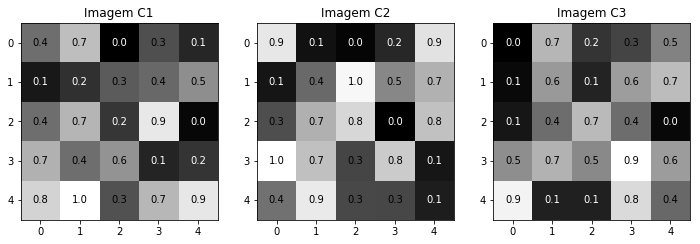

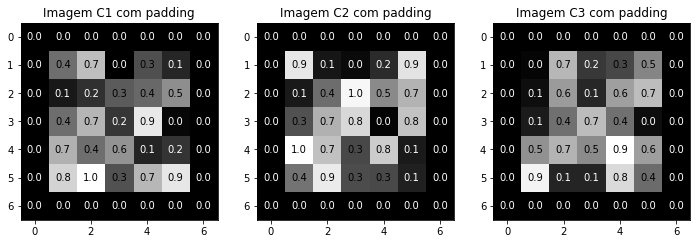

In [5]:
# Gera 1 imagem de 3 canais (RGB) de tamanho 5x5 aleatoriamente 
np.random.seed(1)
x = np.random.rand(1, 3, 5, 5)
print ("x.shape =", x.shape)

# Adiciona o padding de 1 nas imagens geradas aleatoriamente
x_pad = zero_pad(x, 1)
print ("x_pad.shape =", x_pad.shape)

# Exibe uma das imagens com e sem a aplicacao do padding
show_img(x[0][0], x[0][1], x[0][2], 'Imagem C1', 'Imagem C2', 'Imagem C3')
show_img(x_pad[0][0], x_pad[0][1], x_pad[0][2], 'Imagem C1 com padding', 'Imagem C2 com padding', 'Imagem C3 com padding')
            

# 3 - Função de Convolução

<img src="images/convolucao.gif">

[Função np.multiply](https://docs.scipy.org/doc/numpy/reference/generated/numpy.multiply.html)

[Função np.sum](https://docs.scipy.org/doc/numpy/reference/generated/numpy.sum.html)

In [6]:
def conv_single_step(slice_window_prev, W, b):
    """
    Aplica a convolucao do filtro 'W' em uma unica janela 'slice_window_prev' da imagem.
    
    Arguments:
    window -- janela da imagem de shape (n_C_prev, f, f) onde 'n_C_prev' representa a quantidade de canais de uma imagem de tamanho 'f'x'f'
    W -- Filtro (Weight parameters) de convolução de shape igual a janela da imagem (n_C_prev, f, f)
    b -- Bias a ser adicionado no resultado da convolucao - matriz de shape (1, 1, 1)
    
    Returns:
    Z -- um valor escalar, resultado da convolucao do filtro (W, b) na janela da imagem de entrada
    """

    # Multiplica os elementos de 'slice_window_prev' com 'W' (não adiciona o Bias ainda).
    s = np.multiply(slice_window_prev, W)
    # Soma todos os elementos de 's'.
    Z = np.sum(s)
    # Adiciona o Bias a Z (realiza o cast de 'b' para float() para forçar 'Z' retornar um valor escalar).
    Z = Z + b.astype(float)

    return Z

Bias: [[[-2.13483482]]]
Conv. result: [[1.79096919]] + [[3.82477831]] + [[1.00330289]] + [[[-2.13483482]]]
Conv. result: [[[4.48421557]]]


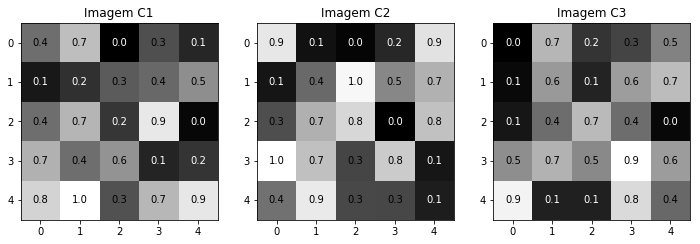

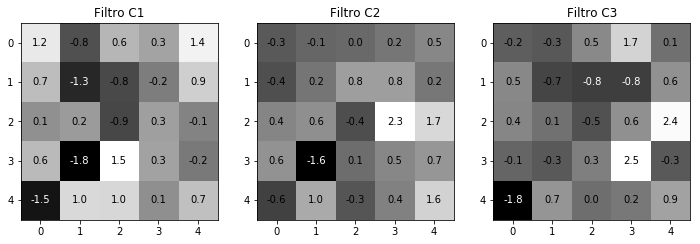

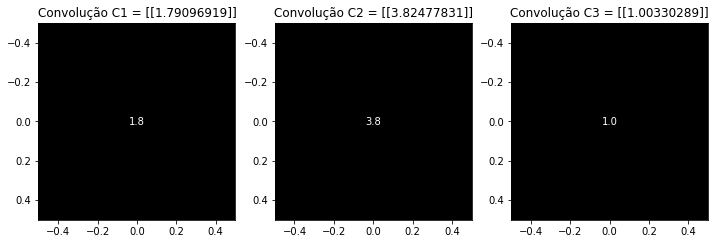

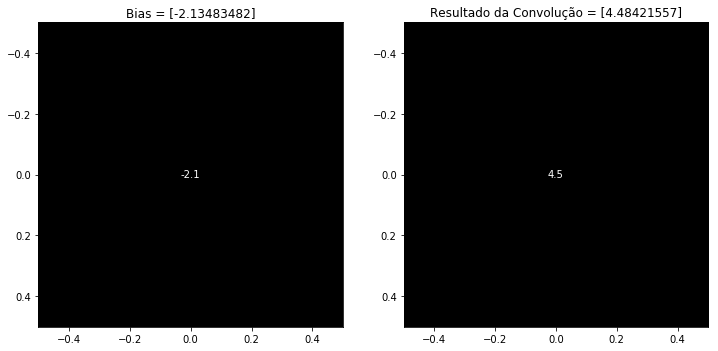

In [7]:
# Gera 1 imagem de 3 canais (RGB) de tamanho 5x5 aleatoriamente
np.random.seed(1)
slice_window_prev = np.random.rand(3, 5, 5)
# Gera 3 filtros de convolucao de tamanho 5x5 aleatoriamente 
W = np.random.randn(3, 5, 5)
# Gera o Bias aletoriamente (será acrescentado na convolução -> Z = W + b )
b = np.random.randn(1, 1, 1)

# Realiza a convolucao de cada canal separadamente para plotar as imagens
conv_c1 = conv_single_step(slice_window_prev[0], W[0], np.zeros((1,1)))
conv_c2 = conv_single_step(slice_window_prev[1], W[1], np.zeros((1,1)))
conv_c3 = conv_single_step(slice_window_prev[2], W[2], np.zeros((1,1)))

# Exibe o resultado das convoluções
show_img(slice_window_prev[0], slice_window_prev[1], slice_window_prev[2], 'Imagem C1', 'Imagem C2', 'Imagem C3')
show_img(W[0], W[1], W[2], 'Filtro C1', 'Filtro C2', 'Filtro C3')
show_img(conv_c1, conv_c2, conv_c3, f'Convolução C1 = {conv_c1}', f'Convolução C2 = {conv_c2}', f'Convolução C3 = {conv_c3}')

# Calcula a convolução completa
Z = conv_single_step(slice_window_prev, W, b)
show_img(b[0], Z[0], None, f'Bias = {b[0][0]}', f'Resultado da Convolução = {Z[0][0]}')

print(f'Bias: {b}')
print(f'Conv. result: {conv_c1} + {conv_c2} + {conv_c3} + {b}')
print(f'Conv. result: {Z}')

In [8]:
def conv_forward(A_prev, W, b, hparameters):
    """
    Implementa a função de convolução
    
    Arguments:
    A_prev -- imagem a ser aplicada a convolução (imagem de saida da camada anterior), numpy array de shape (m, n_C, n_H, n_W) representando um lote de 'm' imagens de 'n_C' canais e tamanho 'n_H' x 'n_W'
    W -- Filtros (Weight parameters) de convolução de shape (n_C, n_C_prev, f, f) onde 'n_C_prev' representa a quantidade de canais de entrada, 'f'x'f' o tamanho do filtro e 'n_C' a quantidade de canais de saida
    b -- Biases, numpy array de shape (n_C, 1, 1, 1)
    hparameters -- objeto (python dictionary) contendo os valores de "stride" and "padding"
        
    Returns:
    Z -- saida da convolução, numpy array de shape (m, n_C, n_H, n_W)
    cache -- cache com os valores de entrada a ser utilizado no backpropagation (conv_backward())
    """
    
    # Recupera as informações de shape das imagens de entrada
    (m, n_C_prev, n_H_prev, n_W_prev) = A_prev.shape
    
    # Recupera as informações de shape dos filtros de convolução
    (n_C, n_C_prev, f, f) = W.shape
    
    # Recupera as informações de stride e padding 
    stride = hparameters['stride']
    pad = hparameters['pad']
    
    # Calcula as dimensões 'n_H' e 'n_W' de saida da convolução
    n_H = int((n_H_prev + 2*pad - f)/stride) + 1
    n_W = int((n_W_prev + 2*pad - f)/stride) + 1
    
    # Inicializa o volume de saida 'Z' com zeros
    Z = np.zeros([m, n_C, n_H, n_W])
    
    # Realiza o padding nas imagens, caso necessário
    A_prev_pad = zero_pad(A_prev, pad)
    
    for i in range(m):                      # itera sobre o lote de exemplos de treinamento
        a_prev_pad = A_prev_pad[i,:,:,:]    # seleciona o ith exemplo de treinamento
        for c in range(n_C):                # itera sobre os canais do volume de saida
            for h in range(n_H):            # itera sobre o eixo vertical do volume de saida
                for w in range(n_W):        # itera sobre o eixo horizontal do volume de saida
                    
                    # encontra os cantos da janela do filtro
                    vert_start = h*stride
                    vert_end = h*stride + f
                    horiz_start = w*stride 
                    horiz_end = w*stride + f
                    
                    # Encontra a janela para a aplicação do filtro de convolução
                    a_slice_prev = a_prev_pad[:,vert_start:vert_end,horiz_start:horiz_end]
                    
                    # Aplica o filtro de convolução
                    Z[i, c, h, w] = conv_single_step(a_slice_prev, W[c, :, :, :], b[c,:,:,:])
    
    # Verificando se o shape da saida está correto
    assert(Z.shape == (m, n_C, n_H, n_W))
    
    # Guarda a passagem em cache para ser utilizado no backpropagation
    cache = (A_prev, W, b, hparameters)
    
    return Z, cache

### Executando a função de convolução criada

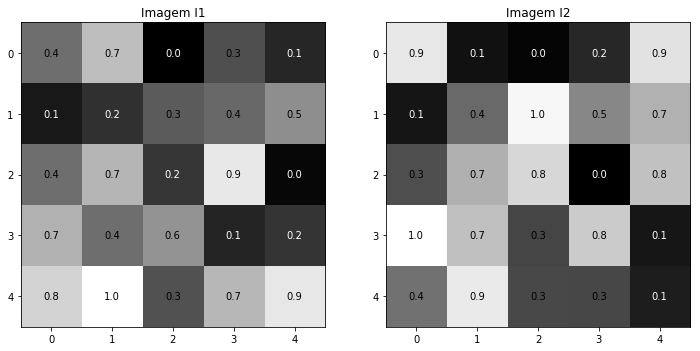

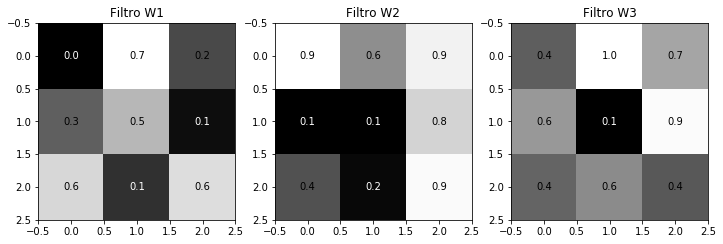

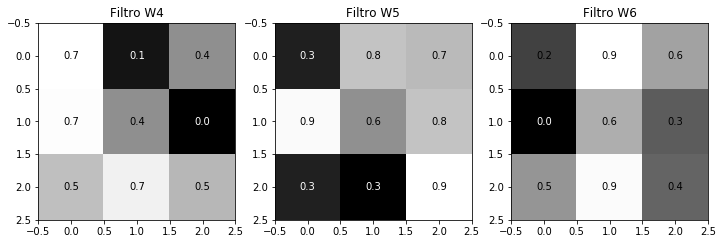

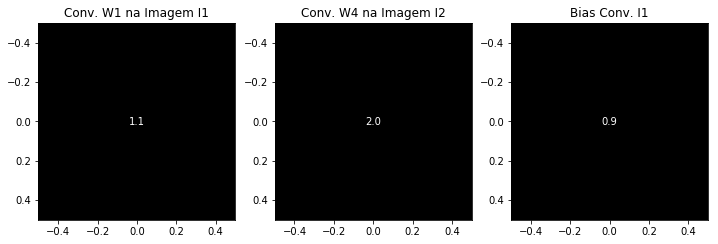

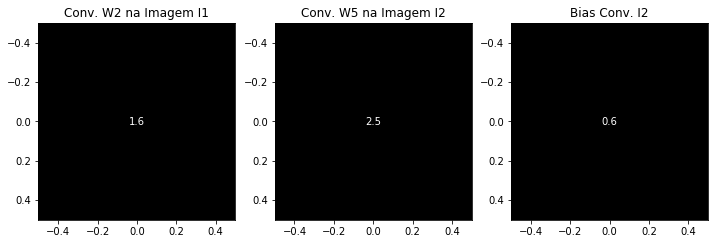

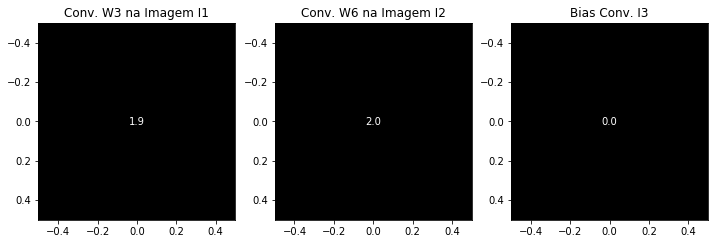

In [10]:
np.random.seed(1)
A_prev = np.random.rand(1,2,5,5)
W = np.random.rand(3,2,3,3)
b = np.random.rand(3,1,1,1)
hparameters = {"pad" : 0, "stride": 1}

# Exibe as 2 imagens geradas aleatoriamente
show_img(A_prev[0][0], A_prev[0][1], None, 'Imagem I1', 'Imagem I2', '')
# Exibe os 6 filtros gerados aleatorimente
show_img(W[0][0], W[1][0], W[2][0], 'Filtro W1', 'Filtro W2', 'Filtro W3')
show_img(W[0][1], W[1][1], W[2][1], 'Filtro W4', 'Filtro W5', 'Filtro W6')

# Exibe o resultado da aplicação de uma única janela de convolução dos filtros W1 e W4 nas imagens I1 e I2
# Primeiro pixel (canto superior esquerdo)
conv_w1_i1 = conv_single_step(A_prev[0][0][0:3, 0:3], W[0][0], np.zeros((1,1)))
conv_w4_i1 = conv_single_step(A_prev[0][1][0:3, 0:3], W[0][1], np.zeros((1,1)))
show_img(conv_w1_i1, conv_w4_i1, b[0][0], 'Conv. W1 na Imagem I1', 'Conv. W4 na Imagem I2', 'Bias Conv. I1')

# Exibe o resultado da aplicação de uma única janela de convolução dos filtros W2 e W5 nas imagens I1 e I2
# Primeiro pixel (canto superior esquerdo)
conv_w2_i1 = conv_single_step(A_prev[0][0][0:3, 0:3], W[1][0], np.zeros((1,1)))
conv_w5_i1 = conv_single_step(A_prev[0][1][0:3, 0:3], W[1][1], np.zeros((1,1)))
show_img(conv_w2_i1, conv_w5_i1, b[1][0], 'Conv. W2 na Imagem I1', 'Conv. W5 na Imagem I2', 'Bias Conv. I2')

# Exibe o resultado da aplicação de uma única janela de convolução dos filtros W3 e W6 nas imagens I1 e I2
# Primeiro pixel (canto superior esquerdo)
conv_w3_i1 = conv_single_step(A_prev[0][0][0:3, 0:3], W[2][0], np.zeros((1,1)))
conv_w6_i1 = conv_single_step(A_prev[0][1][0:3, 0:3], W[2][1], np.zeros((1,1)))
show_img(conv_w3_i1, conv_w6_i1, b[2][0], 'Conv. W3 na Imagem I1', 'Conv. W6 na Imagem I2', 'Bias Conv. I3')


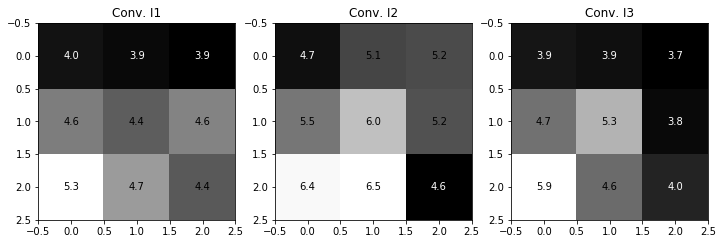

In [11]:
# Executando a convolução completa na imagem por meio do método criado
Z, cache_conv = conv_forward(A_prev, W, b, hparameters)

show_img(Z[0][0], Z[0][1], Z[0][2], 'Conv. I1', 'Conv. I2', 'Conv. I3')


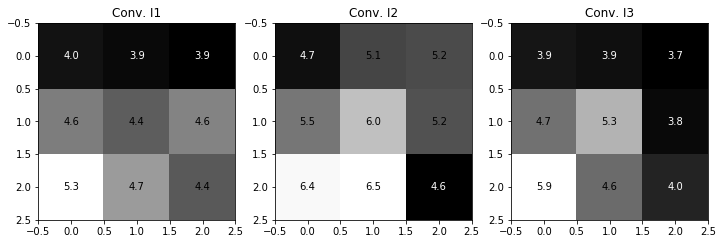

In [13]:
# Executando a convolução completa na imagem por meio do framework PyTorch
# Verificando que o resultado é o mesmo do nosso método criado...

import torch
import torch.nn as nn

# Cria no PyTorch as duas imagens de entrada iguais as imagens geradas aleatoriamente anteriormente
input = torch.from_numpy(A_prev).type(torch.FloatTensor)
# Cria no PyTorch o Bias igual ao Bias gerado aleatoriamente anteriormente
bias = torch.from_numpy(np.array([b[0][0][0][0], b[1][0][0][0], b[2][0][0][0]])).type(torch.FloatTensor)
# Cria no PyTorch os filtros de convolução iguais aos filtros gerados aleatoriamente anteriormente
filter = torch.from_numpy(W).type(torch.FloatTensor)

# Cria a camada de convolução no PyTorch
conv = nn.Conv2d(2, 3, kernel_size=3, bias=True)
# Especifica os filtros
conv.weight = torch.nn.Parameter(filter)
# Especifica o Bias
conv.bias = torch.nn.Parameter(bias)

# Executa a camada de convolução no PyTorch
output = conv(input)

# Exibe o resultado
show_img(output[0][0].detach().numpy(), output[0][1].detach().numpy(), output[0][2].detach().numpy(), 'Conv. I1', 'Conv. I2', 'Conv. I3')

# 4 - Função de Ativação (ReLU)

<img src="images/relu.jpeg" style="width:500px;height:200px;">

In [9]:
def relu(Z):
    """
    Implementação da função de ativação ReLU
    
    Arguments:
    Z -- imagem a ser aplicada a função de ativação ReLU
    
    Returns:
    Z -- saida da função de ativação ReLU
    """
    return np.maximum(Z, 0, Z)

# 5 - Função de Pooling

<img src="images/maxpool_animation.gif" style="width:500px;height:200px;">


In [14]:
def pool_forward(A_prev, hparameters, mode = "max"):
    """
    Implementa a função de pooling
    
    Arguments:
    A_prev -- imagem a ser aplicada o pooling (imagem de saida da camada anterior), numpy array de shape (m, n_C, n_H, n_W) representando um lote de 'm' imagens de 'n_C' canais e tamanho 'n_H' x 'n_W'
    hparameters -- objeto (python dictionary) contendo os valores de "stride" e o tamanho da máscara 'f'
    mode -- tipo da função de pooling ('max' ou 'average')
        
    Returns:
    A -- imagem de saída da função de pooling, numpy array de shape (m, n_C, n_H, n_W)
    cache -- cache com os valores de entrada a ser utilizado no backpropagation (pool_backward())
    """
    
    # Recupera as dimensões da imagem
    (m, n_C_prev, n_H_prev, n_W_prev) = A_prev.shape
    
    # Recupera os parametros 'stride' e tamanho da máscara 'f'x'f'
    f = hparameters["f"]
    stride = hparameters["stride"]
    
    # Define as dimensões da imagem de saida
    n_H = int(1 + (n_H_prev - f) / stride)
    n_W = int(1 + (n_W_prev - f) / stride)
    n_C = n_C_prev
    
    # Inicializa a matriz de saída 'A'
    A = np.zeros((m, n_C, n_H, n_W))
    
    for i in range(m):                 # itera sobre os exemplos de treinamento
        for c in range (n_C):          # itera sobre os canais do volume de saída
            for h in range(n_H):       # itera sobre o eixo vertical do volume de saída
                for w in range(n_W):   # itera sobre o eixo horizontal do voume de saída
                    
                    # encontra os cantos da janela da mácara de pooling
                    vert_start = h*stride
                    vert_end = h*stride +f
                    horiz_start = w*stride
                    horiz_end = w*stride + f
                    
                    # Encontra a janela para a aplicação da função de pooling
                    a_prev_slice = A_prev[i, c, vert_start:vert_end, horiz_start:horiz_end]
                    
                    # Aplica a operação de pooling
                    if mode == "max":
                        A[i, c, h, w] = np.max(a_prev_slice)
                    elif mode == "average":
                        A[i, c, h, w] = np.mean(a_prev_slice)
    
    # Guarda a passagem em cache para ser utilizado no backpropagation
    cache = (A_prev, hparameters)
    
    # Verificando se o shape da saida está correto
    assert(A.shape == (m, n_C, n_H, n_W))
    
    return A, cache

### Executando a função de pooling criada

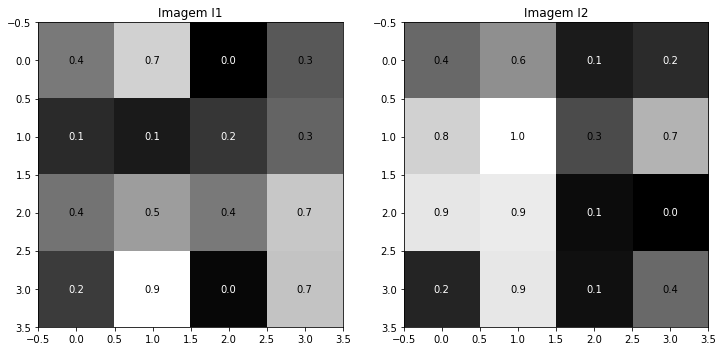

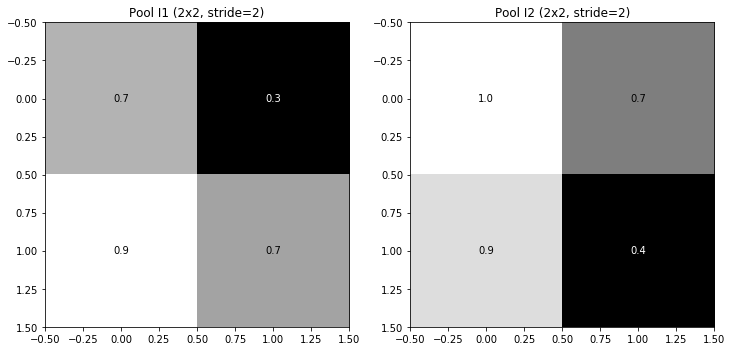

In [51]:
np.random.seed(1)
A_prev = np.random.rand(1,2,4,4)
hparameters = {"stride" : 2, "f": 2}

A, cache_pool = pool_forward(A_prev, hparameters)

# Exibe as 2 imagens geradas aleatoriamente
show_img(A_prev[0][0], A_prev[0][1], None, 'Imagem I1', 'Imagem I2', '')
# Exibe a saída da camada de pooling
show_img(A[0][0], A[0][1], None, 'Pool I1 (2x2, stride=2)', 'Pool I2 (2x2, stride=2)', '')

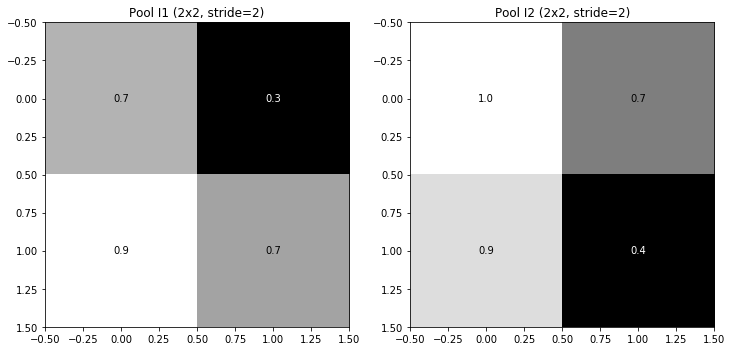

In [53]:
# Executando o pooling na imagem por meio do framework PyTorch
# Verificando que o resultado é o mesmo do nosso método criado...

import torch
import torch.nn as nn

# Cria no PyTorch as duas imagens de entrada iguais as imagens geradas aleatoriamente anteriormente
input_pool_pytorch = torch.from_numpy(A_prev).type(torch.FloatTensor)

# Cria a camada de pooling no PyTorch
pool_pytorch = nn.MaxPool2d(kernel_size=2, stride=2)

# Executa a camada de polling no PyTorch
output_pool_pytorch = pool_pytorch(input_pool_pytorch)

# Exibe o resultado
show_img(output_pool_pytorch[0][0].detach().numpy(), output_pool_pytorch[0][1].detach().numpy(), None, 'Pool I1 (2x2, stride=2)', 'Pool I2 (2x2, stride=2)', '')

# 6 - Calculando o backpropagation para a convolução

In [47]:
def conv_backward(dZ, cache):
    """
    Implementa o backpropagation para a função de convolução
    
    Arguments:
    dZ -- gradient of the cost with respect to the output of the conv layer (Z), numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache da passagem anterior, saída da função de convolução executada anteriormente - conv_forward()
    
    Returns:
    dA_prev -- gradient of the cost with respect to the input of the conv layer (A_prev),
               numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    dW -- gradient of the cost with respect to the weights of the conv layer (W)
          numpy array of shape (f, f, n_C_prev, n_C)
    db -- gradient of the cost with respect to the biases of the conv layer (b)
          numpy array of shape (1, 1, 1, n_C)
    """
    
    # Recupera as informações do cache da passagem anterior
    (A_prev, W, b, hparameters) = cache
    
    # Recupera as informações de shape das imagens de entrada da passagem anterior
    (m, n_C_prev, n_H_prev, n_W_prev) = A_prev.shape
    
    # Recupera as informações de shape dos filtros de convolução da passagem anterior
    (n_C, n_C_prev, f, f) = W.shape
    
    # Recupera as informações de stride e padding da passagem antetior
    stride = hparameters["stride"]
    pad = hparameters["pad"]
    
    # Recupera as informações de shape para o novo lote de imagens de treinamento
    (m, n_C, n_H, n_W) = dZ.shape
    
    # Inicializa dA_prev, dW, db com zeros
    dA_prev = np.zeros((m, n_C_prev, n_H_prev, n_W_prev))                           
    dW = np.zeros((n_C, n_C_prev, f, f))
    db = np.zeros((n_C, 1, 1, 1))
    print(f'dA_prev: {dA_prev.shape}')
    print(f'dW: {dW.shape}')
    print(f'db: {db.shape}')

    # Realiza o padding, caso necessario
    A_prev_pad = zero_pad(A_prev, pad)
    dA_prev_pad = zero_pad(dA_prev, pad)
    
    for i in range(m):                       # Itera sobre os exemplos de treinamento
        
        # seleciona a ith imagem de treinamento
        a_prev_pad = A_prev_pad[i]
        da_prev_pad = dA_prev_pad[i]
        
        for c in range(n_C):                 # itera sobre os canais
            for h in range(n_H):             # itera sobre o eixo vertical
                for w in range(n_W):         # itera sobre o eixo horizontal
                    
                    # Encontra os cantos da janela do filtro
                    vert_start = h
                    vert_end = vert_start + f
                    horiz_start = w
                    horiz_end = horiz_start + f
                    
                    # Encontra a janela para a aplicação do filtro de convolução
                    a_slice = a_prev_pad[:, vert_start:vert_end, horiz_start:horiz_end]

                    # Update gradients for the window and the filter's parameters using the code formulas given above
                    da_prev_pad[:, vert_start:vert_end, horiz_start:horiz_end] += W[c,:,:,:] * dZ[i, c, h, w]
                    dW[c,:,:,:] += a_slice * dZ[i, c, h, w]
                    db[c,:,:,:] += dZ[i, c, h, w]
                    
        # Set the ith training example's dA_prev to the unpaded da_prev_pad (Hint: use X[pad:-pad, pad:-pad, :])
        if (pad > 0):
            dA_prev[i, :, :, :] = da_prev_pad[:, pad:-pad, pad:-pad]   
        else:
            dA_prev[i, :, :, :] = da_prev_pad[:, :, :]
        
    # Verificando se o shape da saida está correto
    assert(dA_prev.shape == (m, n_C_prev, n_H_prev, n_W_prev))
    
    return dA_prev, dW, db

In [49]:
np.random.seed(1)
dA, dW, db = conv_backward(Z, cache_conv)
#print(Z)
#print(cache_conv)
#(A_prev_t, W_t, b_t, hparameters_t) = cache_conv
#show_img(W_t[0][0], W_t[1][0], W_t[2][0], 'Filtro W1', 'Filtro W2', 'Filtro W3')
#show_img(W_t[0][1], W_t[1][1], W_t[2][1], 'Filtro W4', 'Filtro W5', 'Filtro W6')

print("dA_mean =", np.mean(dA))
print("dW_mean =", np.mean(dW))
print("db_mean =", np.mean(db))

print('-'*20)
print(dA)
print('-'*20)
print(dW)
print('-'*20)
print(db)

dA_prev: (1, 2, 5, 5)
dW: (3, 2, 3, 3)
db: (3, 1, 1, 1)
dA_mean = 23.790271161446057
dW_mean = 20.57590393660102
db_mean = 42.993433132004306
--------------------
[[[[ 6.23593915 15.85317678 23.70869813 17.31444065  7.97244183]
   [11.43150522 26.11149278 42.21988024 30.82040122 16.15488699]
   [19.53611255 39.74068868 63.56177831 45.28508659 24.49229636]
   [12.8755348  20.77696775 39.97037644 27.21950643 16.92493786]
   [ 8.23714323 12.63293709 22.09787285 14.43165231  8.52200878]]

  [[ 5.37628714 12.97519105 20.50542586 15.22979702  7.50913916]
   [13.19464416 29.56128652 43.78070012 29.50308512 13.18614935]
   [21.21185979 47.30999417 68.93435642 46.17534518 20.86201562]
   [16.18707507 34.75620396 47.47141841 31.1947311  13.42903968]
   [ 8.17860187 17.70764146 25.67163986 17.62994821  7.84421876]]]]
--------------------
[[[[13.68693578 16.67630845 12.91935076]
   [16.26999422 17.18417716 14.44068948]
   [22.81669189 21.58995813 17.23522864]]

  [[19.33966043 17.38720164 21.92293